Linear Discriminant Analysis is based on the idea of finding a linear combination of features that separates two or more classes of objects. Bayes Theorem is used to classify new data points: LDA makes predictions by calculating the probability of whether an input data set will belong to a particular output.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Linear discriminant analysis assumes that the underlying data distribution is normal and that each class has equal covariance matrix. Therefore, we use the transformed (through Box-Cox transformation) data.

In [2]:
# import training set
train = pd.read_csv('/Users/alessia/Desktop/churn/trans.csv')

# only select the transformed (continuous) predictor variables
X = train[['CreditScore_trans', 'Age_trans', 'EstimatedSalary_trans', 'Balance', 'Tenure', 'NumOfProducts']]
y = train['Exited']

In [3]:
# split training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
X_test.to_csv(r"/Users/alessia/Desktop/churn/X_test_trans.csv", index=False)
y_test.to_csv(r"/Users/alessia/Desktop/churn/y_test_trans.csv", index=False)

In [4]:
# parameter grid
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}

# Linear Discriminant Analysis
LDA_classifier = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=LDA_classifier, param_grid=param_grid,
                           scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train.values.ravel()) 

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: {:.4f}".format(grid_search.best_score_))

Best Parameters:  {'shrinkage': None, 'solver': 'svd'}
Best AUC: 0.7785


/Users/alessia/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alessia/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alessia/anaconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alessia

In [5]:
LDA = grid_search.best_estimator_ # select best estimator based on best parameters

# refit model on training set
LDA.fit(X = X_train, y = y_train.values.ravel())

# predict on the training set
y_pred_train = LDA.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# AUC on training set
y_probs_train = LDA.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_test = LDA.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# AUC on test set
y_probs_test = LDA.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8112
AUC on training set is 0.7786351273748782
Accuracy on test set: 0.8120
AUC on test set is 0.7821101513532763


In [6]:
# define confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Reds', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

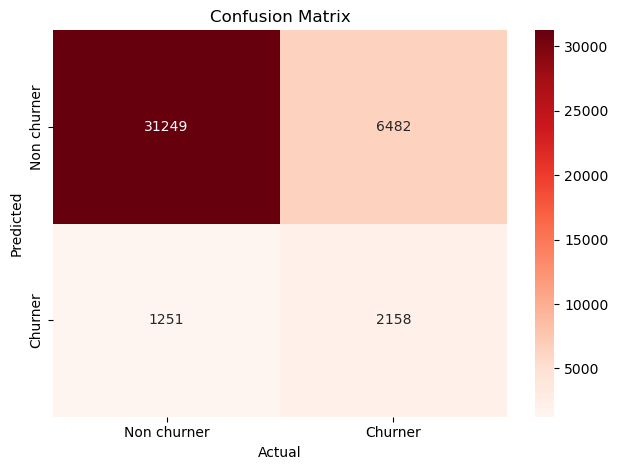

In [7]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_test,y_test)

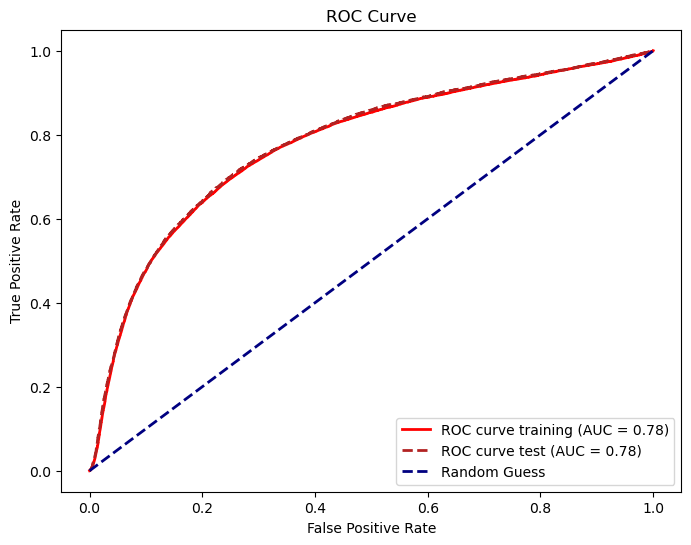

In [8]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'firebrick', linestyle='--', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [9]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test = precision_score(y_test, y_pred_test)
# recall
recall_test = recall_score(y_test, y_pred_test)
# f1-measure
f1_test = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test))
print('Recall on the test set is {}'.format(recall_test))
print('f1-measure on the test set is {}'.format(f1_test))

Precision on the test set is 0.6330302141390437
Recall on the test set is 0.24976851851851853
f1-measure on the test set is 0.35820400033197775


In [10]:
# save model
model_name='lda.pkl'
model_file=open(model_name,'wb')
pickle.dump(LDA, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)